In [180]:
import glob
import os
import numpy as np
import pandas as pd
import sys
import series_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from hmmlearn import hmm
import hmm_helper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
import itertools
import tsfel
sys.path.insert(0, os.path.abspath('MMPE'))
import mmpe_util

In [181]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"
np.random.seed(42)

In [183]:
schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'

In [184]:
def get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer):    

    subject_list = []
    all_data = []
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        series = series.T
        series['network'] = schafer['network']
        series_nolimbic = series[series.network!='Limbic']
        del series_nolimbic["network"]
        df_series = series_nolimbic.T
        all_data.append(df_series.values)
        subject_list.append(subject)
  
    return all_data, subject_list
    

def get_all_data(scans, stimuli,subjects, dirpath, parcel,schafer): 
    all_c = []
    all_subjects = []

    for scan in scans:

        for stimulus in stimuli:
  
            all_data, subject_list = get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer)
            all_subjects = all_subjects +  subject_list
            all_c = all_c + all_data
          
    return all_c, all_subjects

In [316]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Matriz de confusión', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
#    cbar.ax.set_yticklabels(['< -1', '0', '> 1']) 
    cbar = plt.colorbar(ticks=[-1, 1])
    cbar.ax.set_yticklabels([cm.min(), cm.max()]) 
#    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2. + 0.2
    print(thresh)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
                 
    plt.tight_layout()
    plt.ylabel('Valores Reales')
    plt.xlabel('Valores Predicción')

In [186]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='Curva ROC (area = %.2f)' %auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance')
    plt.title('curva ROC')
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderros positivos')
    plt.grid()
    plt.legend()
    plt.show()

In [187]:
networks_id = schafer[schafer.network!='Limbic']["network_id"].values
order_index = np.argsort(networks_id)
order_networks = networks_id[order_index]
change_index = np.where(order_networks[:-1] != order_networks[1:])[0] +1

In [371]:
window_size = 50
overlap = 0.5
tao = 1
d = 3
s = 4

# Average pre

In [372]:
occ_pre, subjects_list_occ_pre = get_all_data(['_scan_restpre'], ['ses-occ'], subjects, dirpath, parcel,schafer)
fro_pre, subjects_list_fro_pre = get_all_data(['_scan_restpre'], ['ses-fro'], subjects, dirpath, parcel,schafer)


pre_average = list((np.array(fro_pre) + np.array(occ_pre))/2)

In [373]:

pre_average_array =  np.swapaxes(np.dstack(pre_average), 0,2)
pre_average_array.shape

(23, 376, 600)

In [374]:
reorder_x_pre = pre_average_array[:,order_index,:]
X_pre_networks = np.split(reorder_x_pre, change_index, axis = 1)
len(X_pre_networks)

15

## Calculate mmspe per subject per networks

In [375]:
mmspe_subjects_pre = []
for network_array in X_pre_networks:
    network_mmspe = []
    for subject_array in network_array:
        windows = tsfel.signal_window_splitter(subject_array.T, window_size, overlap=overlap)
        mmspe = []
        for window in windows:
            segment = window.T
            ms = mmpe_util.mmpe(segment,d,tao,s)
            mmspe.append(ms)
       
        network_mmspe.append(np.array(mmspe))
    mmspe_subjects_pre.append(np.array(network_mmspe)) 

/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe_util.py:48: RuntimeWarning: divide by zero encountered in log2
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe_util.py:48: RuntimeWarning: invalid value encountered in multiply
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))


In [376]:
mmspe_pre = np.concatenate(mmspe_subjects_pre,axis=2)
mmspe_pre.shape

(23, 23, 60)

# OCC

In [377]:
occ_post, subjects_list_occ_post =  get_all_data(['_scan_restpost'], ['ses-occ'], subjects, dirpath, parcel,schafer)

In [378]:
cat_subjects = pd.get_dummies(subjects_occ)

subjects_id_occ = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Post']

In [379]:
occ_array = np.swapaxes(np.dstack(occ_post), 0,2) 
occ_array.shape

(23, 376, 600)

In [380]:
reorder_x_occ = occ_array[:,order_index,:]
X_occ_networks = np.split(reorder_x_occ, change_index, axis = 1)
len(X_occ_networks)

15

## Calculate mmspe per subject per networks

In [381]:
mmspe_subjects_occ = []
for network_array in X_occ_networks:
    network_mmspe = []
    for subject_array in network_array:
        windows = tsfel.signal_window_splitter(subject_array.T, window_size, overlap=overlap)
        mmspe = []
        for window in windows:
            segment = window.T
            ms = mmpe_util.mmpe(segment,d,tao,s)
            mmspe.append(ms)
       
        network_mmspe.append(np.array(mmspe))
    mmspe_subjects_occ.append(np.array(network_mmspe)) 

In [382]:
mmspe_occ = np.concatenate(mmspe_subjects_occ,axis=2)
mmspe_occ.shape

(23, 23, 60)

In [383]:
all_occ = np.concatenate((mmspe_pre, mmspe_occ), axis=0)
subjects_occ = subjects_list_occ_pre + subjects_list_occ_post
y_occ = [0]*len(subjects_list_occ_pre) + [1]*len(subjects_list_occ_post)
all_occ.shape

(46, 23, 60)

In [384]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,17)]
}

In [385]:
grid_search_g_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_occ.fit(X = all_occ, y = y_occ, groups = subjects_id_occ)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('lda', LinearDiscriminantAnalysis3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GaussianHMM(covariance_type='full',
                                                                             n_iter=100,
                                                                             random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GaussianHMM(covariance_type='full',
                                                          n_iter=100,
                                                          random_state=42)],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14, 15,
                                                 16]},
             scoring='accuracy')

In [388]:
print('Best Score: %s' % grid_search_g_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_occ.best_params_)

Best Score: 0.782608695652174
Best Hyperparameters: {'model__hmm_model': GaussianHMM(covariance_type='full', n_iter=100, random_state=42), 'model__n_components': 11}


## PCA

In [364]:
base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm")
model_hmm = hmm_helper.HMM_classifier(base_model)


pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.85,0.9, 0.95, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,17)],
                'model__n_mix': [*range(2,10)]
}

In [ ]:
grid_search_m_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy", verbose = 3,n_jobs=-1)

grid_search_m_occ.fit(X = all_occ, y = y_occ, groups = subjects_id_occ)

Fitting 23 folds for each of 432 candidates, totalling 9936 fits
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   0.9s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.3s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.5s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.5s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, 

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.7;, score=nan total time=   0.7s[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.000 total time=   1.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.000 total time=   1.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.000 total time=   1.2s
[CV 19/23] END

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.4s[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.0s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.2s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.4s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.3s
[CV 11/23] END

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.3s[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.000 total time=   1.4s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.4s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.3s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=   1.4s
[CV 23/23] END mode

[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.6s[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.3s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=   1.4s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=   1.4s
[CV 21/23] END 

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.4s[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.4s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=   1.5s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.000 total time=   1.3s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=   1.3s
[CV 4/23] END 

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.3s[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=   1.4s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.2s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.3s
[CV 16/23] END

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.7s[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.000 total time=   1.5s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.5s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=   1.3s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.2s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=   1.4s
[CV 1/23] EN

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.4s[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.3s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.4s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.2s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=   1.2s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.3s
[CV 13/23] E

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.5s[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.4s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.4s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=   1.4s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.000 total time=   1.4s
[CV 3/23] END mod

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.3s[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=   1.4s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.3s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.5s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.3s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=   1.3s
[CV 22/23] END 

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.6s[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.000 total time=   1.3s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.2s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.000 total time=   1.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.5s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=   1.4s
[CV 20/23] END

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.3s[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.000 total time=   1.2s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=   1.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=   1.2s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.000 total time=   1.5s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=   1.5s
[CV 2/23] END m

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.5s[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.3s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.4s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.2s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.2s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.2s
[CV 12/23] 

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.5s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.8;, score=nan total time=   0.4s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.85;, score=nan total time=   0.4s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.6s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.4s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.5s
[CV 10/23] END model

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.8;, score=nan total time=   0.7s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.5s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.7s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.3s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.5s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.5s
[CV 8/23] END model__hmm

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=1;, score=nan total time=   0.2s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.5s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.6s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.4s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.4s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.7s
[CV 3/23] END model__h

[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=nan total time=   0.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.6s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.7s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.5s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.4s
[CV 21/23] END model__hm

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=nan total time=   0.4s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.3s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.4s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.3s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=   1.3s
[CV 22/23] END model

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=nan total time=   0.5s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=   1.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.4s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.4s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.5s
[CV 12/23] END model

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   1.4s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.6s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.7s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.000 total time=   1.5s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=0.000 total time=   1.5s
[CV 3/23] END mod

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.2s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.2s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.7s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.5s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.2s
[CV 20/23] END model__hmm

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.7s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.000 total time=   1.5s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=0.000 total time=   1.4s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.5s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=   1.5s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=1;, score=0.500 total time=   1.5s
[CV 7/23] END

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.2s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.4s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.6s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.5s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.2s
[CV 18/23] END model__hmm_

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.3s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.6s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.3s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.6s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   1.3s
[CV 4/23] END model__hmm_

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   1.8s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.5s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.6s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.5s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.6s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.3s
[CV 5/23] END model__hm

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time=   2.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.0s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.5s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.5s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.5s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=   1.6s
[CV 12/

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.2s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.3s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.3s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.000 total time=   1.4s
[CV 17/23] END model__h

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.5s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=   2.0s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=   1.4s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.5s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.4s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=   1.4s
[CV 19/23] EN

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.7s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.0s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.4s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.4s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=   1.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=   1.4s
[CV 9/23] 

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=   1.6s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.4s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.8s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.6s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.3s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.4s
[CV 3/23] END model_

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=1;, score=nan total time=   0.2s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=nan total time=   0.5s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=nan total time=   0.2s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=nan total time=   0.6s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=nan total time=   0.6s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.5s
[CV 11/23] END model__h

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.7;, score=nan total time=   0.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.6s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.2s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.7s
[CV 15/23] END model

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=nan total time=   0.4s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.6s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.3s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.5s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.4s
[CV 23/23] END model__h

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=nan total time=   0.5s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=nan total time=   0.3s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=nan total time=   0.5s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=nan total time=   0.5s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=nan total time=   1.7s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.2s
[CV 3/23] END model

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=nan total time=   0.8s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=nan total time=   0.5s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.7s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.7s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.5s
[CV 7/23] END model__hmm_m

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=nan total time=   0.8s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.5s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.3s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.2s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.2s
[CV 3/23] END model__hmm_m

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=nan total time=   0.3s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.1s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.3s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.7s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.5s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.3s
[CV 14/23] END model__hmm_mode

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=nan total time=   0.6s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.6s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.3s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.6s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.4s
[CV 23/23] END model__hmm

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=nan total time=   0.9s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.4s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.8s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.4s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.3s
[CV 12/23] END model__hmm

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=nan total time=   0.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.6s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   1.8s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.6s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.8s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=   1.9s
[CV 12/23] END m

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=nan total time=   1.3s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.2s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.3s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=nan total time=   0.3s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.2s
[CV 20/23] END model__hmm_m

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.95;, score=nan total time=   0.9s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.2s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.3s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   1.9s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=   1.7s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.85;, score=0.000 total time=   1.6s
[CV 7/23] END m

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.7;, score=nan total time=   0.5s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.7s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=nan total time=   0.2s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=nan total time=   0.7s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=nan total time=   0.6s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=1;, score=nan total time=   0.3s
[CV 16/23] END model__hmm

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.8;, score=nan total time=   0.3s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.7;, score=nan total time=   0.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.8;, score=nan total time=   0.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=nan total time=   0.8s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=nan total time=   0.7s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=nan total time=   0.2s
[CV 11/23] END mo

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=0.95;, score=nan total time=   1.6s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=1;, score=nan total time=   0.4s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.7;, score=nan total time=   1.5s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=nan total time=   1.7s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=nan total time=   0.8s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=nan total time=   0.4s
[CV 22/23] END model_

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=nan total time=   0.5s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=nan total time=   0.3s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=nan total time=   0.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=nan total time=   0.4s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=nan total time=   0.9s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=nan total time=   0.7s
[CV 20/23] END model__hm

In [390]:
print('Best Score: %s' % grid_search_m_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_m_occ.best_params_)

Best Score: 0.5869565217391305
Best Hyperparameters: {'model__hmm_model': GMMHMM(init_params='cm', params='cm'), 'model__n_components': 12, 'model__n_mix': 2, 'pca__n_components': 0.9}


In [ ]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.85,0.9, 0.95, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,12)]
}

In [ ]:
grid_search_g_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_occ.fit(X = all_occ, y = y_occ, groups = subjects_id_occ)

In [389]:
print('Best Score: %s' % grid_search_g_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_occ.best_params_)

Best Score: 0.782608695652174
Best Hyperparameters: {'model__hmm_model': GaussianHMM(covariance_type='full', n_iter=100, random_state=42), 'model__n_components': 11}


## Best Result

In [112]:
states = 11

base_model = hmm.GaussianHMM(covariance_type='full', n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

cv = LeaveOneGroupOut()

scores_occ = cross_val_score(pipe, all_occ, y_occ, cv = cv, scoring='accuracy', groups = subjects_id_occ)
y_score_occ = cross_val_predict(pipe,  all_occ, y_occ, cv = cv ,method='predict_proba', groups = subjects_id_occ)
y_pred_occ = cross_val_predict(pipe,  all_occ, y_occ, cv = cv, groups = subjects_id_occ,n_jobs=-1)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

In [113]:
scores_occ.mean()

0.782608695652174

GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=100,
            random_state=42)
GaussianHMM(covariance_type='full', n_components=11, n_iter=

In [114]:
y_score_p = y_score_occ[:,1]-y_score_occ[:,0]
auc = metrics.roc_auc_score(y_occ, y_score_p)
auc

0.8052930056710774

In [115]:
error = proportion_confint(np.sum(np.equal(y_pred_occ,y_occ)),len(y_occ),method='jeffreys')
error

(0.6485572791678698, 0.8823845084607068)

In [116]:
fpr, tpr, thresh = metrics.roc_curve(y_occ, y_score_p)

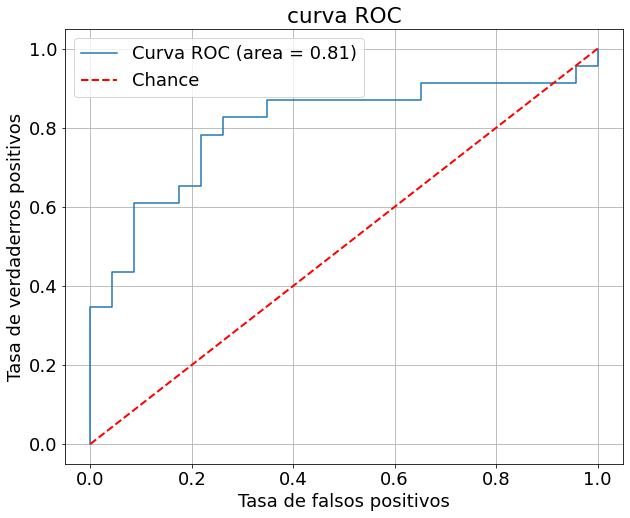

In [117]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [118]:
accuracy_score(y_pred_occ,y_occ)
print(proportion_confint(np.sum(np.equal(y_pred_occ,y_occ)),len(y_occ),method='jeffreys'))
cm = confusion_matrix(y_pred_occ,y_occ)

(0.6485572791678698, 0.8823845084607068)


0.491304347826087


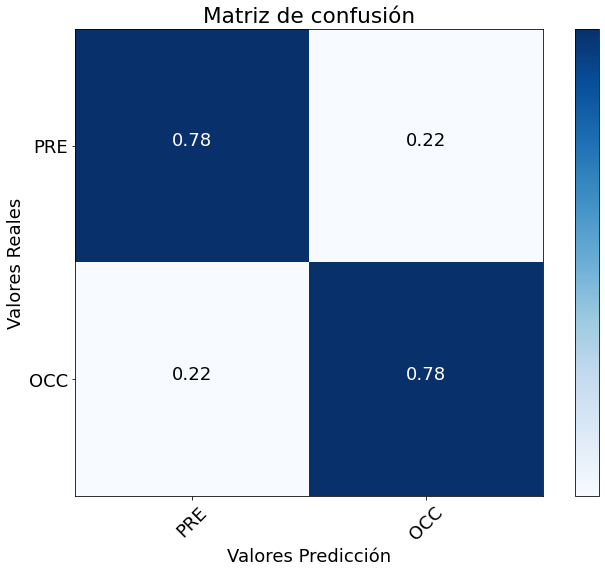

In [119]:

plot_confusion_matrix(cm, ["PRE", "OCC"],normalize=True)

# FRO

In [396]:
fro_post, subjects_list_fro_post =  get_all_data(['_scan_restpost'], ['ses-fro'], subjects, dirpath, parcel,schafer)


In [397]:
fro_array = np.swapaxes(np.dstack(fro_post), 0,2) 
fro_array.shape

(23, 376, 600)

In [398]:
reorder_x_fro =fro_array[:,order_index,:]
X_fro_networks = np.split(reorder_x_fro, change_index, axis = 1)
len(X_fro_networks)

15

In [399]:
mmspe_subjects_fro = []
for network_array in X_fro_networks:
    network_mmspe = []
    for subject_array in network_array:
        windows = tsfel.signal_window_splitter(subject_array.T, window_size, overlap=overlap)
        mmspe = []
        for window in windows:
            segment = window.T
            ms = mmpe_util.mmpe(segment,d,tao,s)
            mmspe.append(ms)
       
        network_mmspe.append(np.array(mmspe))
    mmspe_subjects_fro.append(np.array(network_mmspe)) 

/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe_util.py:48: RuntimeWarning: divide by zero encountered in log2
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe_util.py:48: RuntimeWarning: invalid value encountered in multiply
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))


In [400]:
mmspe_fro = np.concatenate(mmspe_subjects_fro,axis=2)
mmspe_fro.shape

(23, 23, 60)

In [401]:
all_fro = np.concatenate((mmspe_pre, mmspe_fro))
subjects_fro = subjects_list_fro_pre + subjects_list_fro_post
y_fro = [0]*len(subjects_list_fro_pre) + [1]*len(subjects_list_fro_post)
all_fro.shape

(46, 23, 60)

In [402]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=400, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.85,0.9, 0.95, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,15)]
}

In [403]:
grid_search_g_fro= GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_fro.fit(X = all_fro, y = y_fro, groups = subjects_id_fro)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('pca', PCA3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GaussianHMM(covariance_type='full',
                                                                             n_iter=400,
                                                                             random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GaussianHMM(covariance_type='full',
                                                          n_iter=400,
                                                          random_state=42)],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14],
                         'pca__n_components': [0.7, 0.8, 0.85, 0.9, 0.95, 1]},
             scoring='accuracy')

In [404]:
print('Best Score: %s' % grid_search_g_fro.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_fro.best_params_)

Best Score: 0.6739130434782609
Best Hyperparameters: {'model__hmm_model': GaussianHMM(covariance_type='full', n_iter=400, random_state=42), 'model__n_components': 9, 'pca__n_components': 0.85}


In [405]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,17)]
}

In [406]:
grid_search_g_fro = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_fro.fit(all_fro, y = y_fro, groups = subjects_id_fro)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('lda', LinearDiscriminantAnalysis3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GaussianHMM(covariance_type='full',
                                                                             n_iter=400,
                                                                             random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GaussianHMM(covariance_type='full',
                                                          n_iter=400,
                                                          random_state=42)],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14, 15,
                                                 16]},
             scoring='accuracy')

In [457]:
print('Best Score: %s' % grid_search_g_fro.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_fro.best_params_)

Best Score: 0.5434782608695652
Best Hyperparameters: {'model__hmm_model': GaussianHMM(covariance_type='full', n_iter=400, random_state=42), 'model__n_components': 16}


## Best Result

In [458]:
states = 9
n_components_pca=0.85

base_model = hmm.GaussianHMM(n_components=states , covariance_type="full",n_iter=400, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D(n_components=n_components_pca)),("model", model_hmm)])

cv = LeaveOneGroupOut()

scores_fro = cross_val_score(pipe, all_fro, y_fro, cv = cv, scoring='accuracy', groups = subjects_id_fro,n_jobs=-1)
y_score_fro = cross_val_predict(pipe,  all_fro, y_fro, cv = cv ,method='predict_proba', groups = subjects_id_fro,n_jobs=-1)
y_pred_fro = cross_val_predict(pipe,  all_fro, y_fro, cv = cv, groups = subjects_id_fro,n_jobs=-1)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


In [449]:
scores_fro.mean()

0.6739130434782609

In [450]:
y_score_p = y_score_fro[:,1]-y_score_fro[:,0]
auc = metrics.roc_auc_score(y_fro, y_score_p)
auc

0.6049149338374292

In [451]:
metrics.accuracy_score(y_pred_fro,y_fro)

0.6739130434782609

In [452]:
error = proportion_confint(np.sum(np.equal(y_pred_fro,y_fro)),len(y_fro),method='jeffreys')
error

(0.5311005709143959, 0.7956044008396608)

In [414]:
fpr, tpr, thresh = metrics.roc_curve(y_fro, y_score_p)

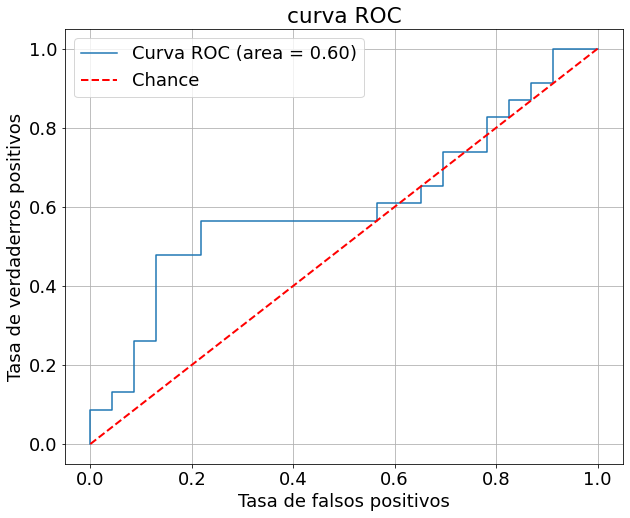

In [415]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [454]:
print(accuracy_score(y_pred_fro,y_fro))
print(proportion_confint(np.sum(np.equal(y_pred_fro,y_fro)),len(y_occ),method='jeffreys'))
cm = confusion_matrix(y_pred_fro,y_fro)
print(cm)

0.6739130434782609
(0.5311005709143959, 0.7956044008396608)
[[20 12]
 [ 3 11]]


In [455]:
y_pred_fro

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0])

0.5928571428571429


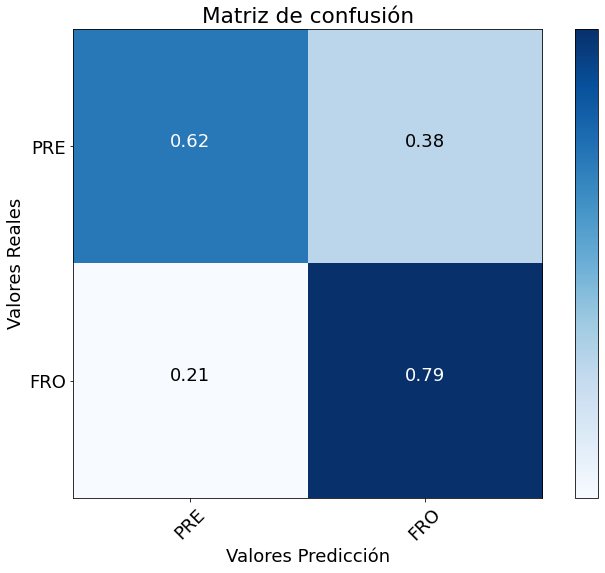

In [417]:

plot_confusion_matrix(cm, ["PRE", "FRO"],normalize=True)

## OCC VS FRO

In [429]:
diff_occ = list(np.array(mmspe_occ)- np.array(mmspe_pre))
diff_fro = list(np.array(mmspe_fro)- np.array(mmspe_pre))

diff_occ = list(mmspe_occ)
diff_fro = list(mmspe_fro)

subjects_diff = subjects_list_occ_post + subjects_list_fro_post
y_diff = [0]*len(subjects_list_occ_post) + [1]*len(subjects_list_fro_post)

all_diff = diff_occ + diff_fro
X_diff = np.array(all_diff)
y_diff = np.array(y_diff)

In [430]:
X_diff.shape

(46, 23, 60)

In [431]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('lda', series_utils.LinearDiscriminantAnalysis3D()),("model", model_hmm)])

parameters = {  'model__hmm_model': [base_model],
                'model__n_components':[*range(8,21)]
             }

In [432]:
grid_search_g_fro_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_fro_occ.fit(X = X_diff, y = y_diff, groups = subjects_diff)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('lda', LinearDiscriminantAnalysis3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GaussianHMM(covariance_type='full',
                                                                             n_iter=100,
                                                                             random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GaussianHMM(covariance_type='full',
                                                          n_iter=100,
                                                          random_state=42)],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14, 15,
                                                 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [434]:
print('Best Score: %s' % grid_search_g_fro_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_fro_occ.best_params_)

Best Score: 0.6086956521739131
Best Hyperparameters: {'model__hmm_model': GaussianHMM(covariance_type='full', n_iter=100, random_state=42), 'model__n_components': 12}


In [435]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=10, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.85,0.9, 0.95, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,15)]
}

In [436]:
grid_search_fro_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_fro_occ.fit(X = X_diff, y = y_diff, groups = subjects_diff)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 's

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('pca', PCA3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GaussianHMM(covariance_type='full',
                                                                             random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GaussianHMM(covariance_type='full',
                                                          random_state=42)],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14],
                         'pca__n_components': [0.7, 0.8, 0.85, 0.9, 0.95, 1]},
             scoring='accuracy')

In [437]:
print('Best Score: %s' % grid_search_fro_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_fro_occ.best_params_)

Best Score: 0.6304347826086957
Best Hyperparameters: {'model__hmm_model': GaussianHMM(covariance_type='full', random_state=42), 'model__n_components': 14, 'pca__n_components': 0.9}


In [438]:
 grid_search_fro_occ.cv_results_

{'mean_fit_time': array([1.56652716, 1.7658816 , 1.84114209, 2.11272124, 2.41118507,
        1.36691828, 1.86115544, 2.04318039, 2.17400526, 2.38071019,
        2.78626665, 1.48446003, 2.02034379, 2.17533916, 2.35836553,
        2.48123239, 3.17894092, 1.73345034, 2.21543712, 2.34778958,
        2.51512807, 2.77657905, 3.42039902, 1.8471917 , 2.48836548,
        2.64364122, 2.92268925, 3.12256448, 3.45520957, 2.04112043,
        2.69185989, 2.84762726, 3.11302471, 3.35231   , 3.98862448,
        2.25661999, 2.90306318, 3.1716324 , 3.44193728, 3.74997903,
        4.52379539, 2.257137  ]),
 'std_fit_time': array([0.26229188, 0.21938327, 0.26188209, 0.24150275, 0.42369424,
        0.09787438, 0.17817641, 0.17448144, 0.25017391, 0.16534992,
        0.27449781, 0.06564684, 0.22205118, 0.27176093, 0.19031623,
        0.29547296, 0.4784045 , 0.25423183, 0.23688113, 0.23312441,
        0.21906974, 0.32845463, 0.61773958, 0.24659642, 0.25019405,
        0.35726142, 0.1884537 , 0.31355492, 0.603

### BEST MODEL


In [439]:
states = 14
n_components_pca=0.9

base_model = hmm.GaussianHMM(n_components=states , covariance_type="full",n_iter=400, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D(n_components=n_components_pca)),("model", model_hmm)])


cv = LeaveOneGroupOut()

scores_fro_occ = cross_val_score(pipe, X_diff, y_diff, cv = cv, scoring='accuracy', groups = subjects_diff,n_jobs=-1)
y_score_fro_occ = cross_val_predict(pipe,  X_diff, y_diff, cv = cv ,method='predict_proba', groups = subjects_diff,n_jobs=-1)
y_pred_fro_occ = cross_val_predict(pipe,   X_diff, y_diff, cv = cv, groups = subjects_diff,n_jobs=-1)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


In [440]:
scores_fro_occ.mean()

0.6739130434782609

In [441]:
y_score_p = y_score_fro_occ[:,1]-y_score_fro_occ[:,0]
auc = metrics.roc_auc_score(y_diff, y_score_p)
auc

0.6956521739130435

In [442]:
accuracy_score(y_diff, y_pred_fro_occ)

0.6739130434782609

In [443]:
error = proportion_confint(np.sum(np.equal(y_pred_fro_occ,y_diff)),len(y_diff),method='jeffreys')
error

(0.5311005709143959, 0.7956044008396608)

In [444]:
fpr, tpr, thresh = metrics.roc_curve(y_diff, y_score_p)

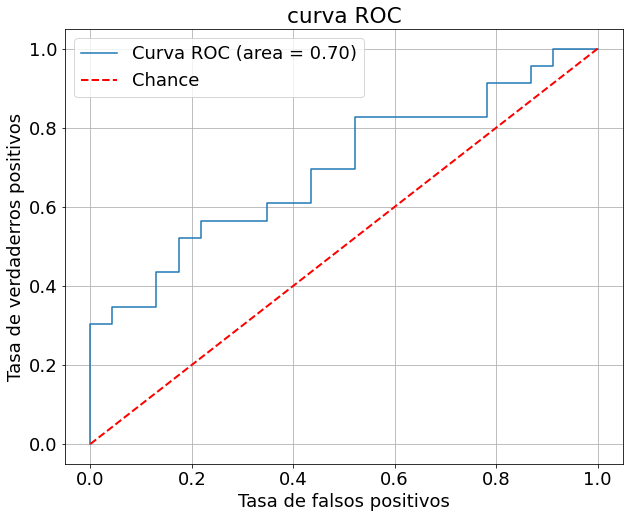

In [445]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [446]:
accuracy_score(y_pred_fro_occ,y_diff)
print(proportion_confint(np.sum(np.equal(y_pred_fro_occ,y_diff)),len(y_diff),method='jeffreys'))
cm = confusion_matrix(y_pred_fro_occ, y_diff)

(0.5311005709143959, 0.7956044008396608)


0.5611111111111111


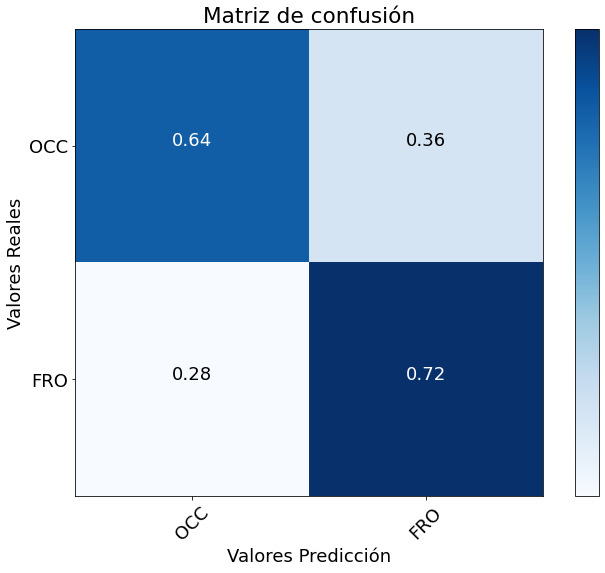

In [448]:
plot_confusion_matrix(cm, ["OCC", "FRO"],normalize=True)